In [1]:
from yt.utilities.cosmology import Cosmology
import h5py
import shutil
import numpy as np
import os
import sys
import illustris_python as il
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import astropy.units as u
from astropy import wcs
from astropy.io import fits
from numbers import Number

basepaths = {'TNG100': ['/virgotng/universe/IllustrisTNG/TNG100-1/output',99],
              'SIMBA': ['/virgotng/universe/Simba/L100n1024FP/output',151],
              'EAGLE': ['/virgotng/universe/Eagle/Eagle100-1/output',28]  
            }

In [2]:
with open('/vera/ptmp/gc/madepa/data/xray_lum.pickle', 'rb') as f:
    lx_dict = pickle.load(f)

with open('/vera/ptmp/gc/madepa/data/masses.pickle', 'rb') as f:
    mass_dict = pickle.load(f)

with open('/vera/ptmp/gc/madepa/data/r200c_radial_data.pickle', 'rb') as f:
    gasfrac_dict = pickle.load(f)

In [3]:
def lx_tot(lx_dict, r200c= True):
    '''
    takes a nested dict { 'sim': { 'haloID': { fields: value(s) } } }
    returns a nested dict { 'sim': { 'haloID': total Lx within rcrit } }
    
    r200c flag decides rcrit as r200c or r500c
    '''
    result = {}
    
    # loop over the sims
    for sim, halo_dict in lx_dict.items():
        # check for r200 or r500
        if r200c :
            r_crit = 'R200c'
        else :
            r_crit = 'R500c'
            
        result[sim] = {} 
        
        # loop over the all the haloIDs to get the gas cell radii and lum
        for index, (haloID, fields) in enumerate(halo_dict.items()):
            for field, values in fields.items():
                # adding mask to calc total lum in rcrit
                if field == 'radius':
                    mask = np.where(fields['radius'] < fields[r_crit])
                    result[sim][haloID] = np.sum(fields['Lx_05_2keV'][mask])
            
    return result

In [4]:
def get_haloIDs(mass_dict):
    haloIDs_dict = {}
    for sim, halo_dict in mass_dict.items():
        haloIDs_dict[sim] = [key for key in halo_dict.keys()]
    
    return haloIDs_dict

In [5]:
def chandra_lum_mock(basepath_dict, halo_dict, eff_area, area, proj):
    
    # ini dict
    lum_dict = {}
    
    # loop over basepaths of sims
    for sim, base in basepath_dict.items():
        
        #ini nested dict
        lum_dict[sim] = {}
        
        # loop over haloIDs and projections
        for haloID in halo_dict[sim]:
            
            # open file and get counts in energy range
            try:
                file = fits.open(f'../fits/no_background/Chandra/{sim}_halo_{haloID}_{proj}_100ks_nb_evt.fits') 
            except:
                print('no mock file for', sim, haloID, proj)
                continue

            # calc counts/s and convert to flux (factor from pimms) and store in dict
            data = file[1].data
            mask = (data['ENERGY']>500) & (data['ENERGY']<2000) # 0.5 - 2 keV
            keV = data['ENERGY'][mask]/1000 # keV

            ar_factor = area/eff_area
            erg_s = np.sum(keV)*u.keV.to(u.erg)/100000 # erg/s
            lum_dict[sim][f'{haloID}'] = erg_s * ar_factor
    
    return lum_dict

def er_lum_mock(basepath_dict, haloIDs_dict, eff_area, area, t_exp, proj):

    # ini dict
    lum_dict = {}
        
    # loop over basepaths of sims
    for sim, base in basepath_dict.items():
        
        #ini nested dict
        lum_dict[sim] = {}
        
        # loop over haloIDs and projections
        for haloID in haloIDs_dict[sim]:
            
            keV = np.array([]) 
            # open and loop over 5 ccd files and get total energy in range
            for i in [1,2,3,4,6]:
                with fits.open(f'../fits/no_background/eROSITA_{sim}_1200s/{sim}_halo_{haloID}_{proj}_1200s_nb_ccd{i}_evt.fits') as f:
                    data = f[1].data
                    mask = (data['SIGNAL']>0.5) & (data['SIGNAL']<2.0)
                    keV = np.concatenate((keV, data['SIGNAL'][mask]))
            
            ar_factor = area/eff_area
            erg_s = np.sum(keV)*u.keV.to(u.erg)/t_exp # erg/s
            lum_dict[sim][f'{haloID}'] = erg_s * ar_factor
    
    return lum_dict

def xmm_lum_mock(basepath_dict, haloIDs_dict, eff_area, area, proj):
    
    # ini dict
    lum_dict = {}
    
    # loop over basepaths of sims
    for sim, base in basepath_dict.items():
        
        #ini nested dict
        lum_dict[sim] = {}
        
        # loop over haloIDs and projections
        for haloID in haloIDs_dict[sim]:

            # open file and get counts in energy range
            try:
                file = fits.open(f'../fits/no_background/XMMfov_10ks/{sim}_halo_{haloID}_{proj}_10ks_nb_evt.fits') 
            except:
                print('no mock file for',sim, haloID, proj)
                continue
            data =  file[1].data
            mask = (data['SIGNAL']>0.5) & (data['SIGNAL']<2.0) # 0.5 - 2 keV
            keV = data['SIGNAL'][mask] # keV

            ar_factor = area/eff_area
            erg_s = np.sum(keV)*u.keV.to(u.erg)/100000 # erg/s
            lum_dict[sim][f'{haloID}'] = erg_s * ar_factor

    return lum_dict

In [6]:
redshift= 0.025
h= 0.6774
Omega_mass= 0.3089
Omega_lam= 0.6911
cosmo = Cosmology(h, Omega_mass, Omega_lam)

d_L = cosmo.luminosity_distance(0.0, redshift).to("cm").value
area = 4* np.pi* d_L**2 
print(area)

lx_intr = lx_tot(lx_dict)
haloIDs = get_haloIDs(mass_dict)

1.5206596050161449e+54


In [7]:
def selection(lum_dict, lx_lim, completeness):
    selected = {}
    unselected = {}
    
    for sim, halos in lum_dict.items():
        selected[sim] = {}
        unselected[sim] = {}
        
        for haloID, lum in halos.items():
            if lum >= lx_lim:
                if np.random.uniform() <= completeness:
                    selected[sim][haloID] = lum
                else:
                    unselected[sim][haloID] = lum
                    
    return selected, unselected

In [8]:
def completeness_vs_mass(masses, lum_dict, nbins=10):
    
    fig, ax = plt.subplots()
    colors = {'TNG100': 'red', 'SIMBA': 'gold', 'EAGLE': 'black'}
    
    for sim, halo_dict in masses.items():
        if sim in colors: 
            mass = []
            mass_all = []

            # Filter halos based on luminosity and calculate gas fraction
            for haloID, values in halo_dict.items():
                if haloID in lum_dict[sim].keys():
                    mass.append(masses[sim][haloID]['M200c'])
                    mass_all.append(masses[sim][haloID]['M200c'])

                else:
                    mass_all.append(masses[sim][haloID]['M200c'])
                        
            # Convert lists to numpy arrays for plotting
            mass = np.array(mass)
            mass_all = np.array(mass_all)
            
            bin_edges = np.linspace(13, 14, nbins+1)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

            # Plot each simulation with a different color
            all_count = np.histogram(mass_all, bins=bin_edges)[0]
            detected = np.histogram(mass, bins=bin_edges)[0]

            completeness = detected/all_count
            ax.plot(bin_centers, completeness, label=sim, color=colors[sim], linestyle='-', linewidth=2)
            

    # Set labels, legend, and plot limits
    ax.set_title('completeness as a function halo mass z=0', fontsize=15)
    ax.set_xlabel('log($M_{\,200c}) \; [M_\odot]$', fontsize=15)
    ax.set_ylabel('completeness', fontsize=15)
    ax.set_ylim(0, 1.01)
    #ax.set_xlim(12.95, 14.05)
    ax.legend()

In [9]:
def plot_fgas_mass(gasfrac_dict, detected, nbins=10):
    fig, ax = plt.subplots()
    colors = {'TNG100': 'red', 'SIMBA': 'gold', 'EAGLE': 'black'}

    for sim, halo_dict in gasfrac_dict.items():
        if sim in colors:
            
            detected_gf = np.ones( len(detected[sim].keys()) )
            detected_mass = np.ones( len(detected[sim].keys()) )
            
            # start an array to store the values of the gas fraction in each bin
            gas_array = np.ones( len(halo_dict.keys()) )
            mass_array = np.ones( len(halo_dict.keys()) )

            for index, (haloID, fields_dict) in enumerate(halo_dict.items()):
                gas_mass = fields_dict['gas_mass_in_bins_cumulative'][-1]
                tot_mass = fields_dict['tot_mass_in_bins_cumulative'][-1]
                gas_frac = gas_mass/tot_mass/0.16
                gas_array[index] = gas_frac
                mass_array[index] = np.log10(tot_mass)
                
            for index, (haloID) in enumerate(detected[sim].keys()):
                gas_mass = gasfrac_dict[sim][haloID]['gas_mass_in_bins_cumulative'][-1]
                tot_mass = gasfrac_dict[sim][haloID]['tot_mass_in_bins_cumulative'][-1]
                gas_frac = gas_mass/tot_mass/0.16
                detected_gf[index] = gas_frac
                detected_mass[index] = np.log10(tot_mass)

            # Plot each simulation with a different color
            ax.scatter(detected_mass, detected_gf, s=12, marker='o', color=colors[sim], label=f'{sim}-detected')
            ax.scatter(mass_array, gas_array, s=12, marker='o', color=colors[sim], label=f'{sim}-undetected', alpha=0.2)

            # Calculate median and stdev in bins
            bin_edges = np.linspace(13, 14, nbins+1)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            
            #for all
            median_gas = []
            std_gas = []
            for k in range(nbins):
                bin_mask = (mass_array >= bin_edges[k]) & (mass_array < bin_edges[k + 1])
                if np.any(bin_mask):  
                    median_gas.append(np.median(gas_array[bin_mask]))
                    std_gas.append(np.std(gas_array[bin_mask]))
                else:
                    median_gas.append(np.nan)
                    std_gas.append(np.nan)

            median_gas = np.array(median_gas)
            std_gas = np.array(std_gas)
            ax.plot(bin_centers, median_gas, color=colors[sim], linestyle='-.', linewidth=2, alpha=0.4)
            ax.fill_between(bin_centers, median_gas - std_gas, median_gas + std_gas,
                            color=colors[sim], alpha=0.2)
            
            #for detected
            median_det = []
            std_det = []
            for k in range(nbins):
                bin_mask = (detected_mass >= bin_edges[k]) & (detected_mass < bin_edges[k + 1])
                if np.any(bin_mask):  
                    median_det.append(np.median(detected_gf[bin_mask]))
                    std_det.append(np.std(detected_gf[bin_mask]))
                else:
                    median_det.append(np.nan)
                    std_det.append(np.nan)
            
            # Convert to numpy arrays for plotting
            median_det = np.array(median_det)
            std_det = np.array(std_det)

            ax.plot(bin_centers, median_det, color=colors[sim], linestyle='-.', linewidth=2, alpha=1)
            ax.fill_between(bin_centers, median_det - std_det, median_det + std_det,
                            color=colors[sim], alpha=0.4)
            

    ax.set_title('normalised gas fraction vs halo mass at z=0', fontsize=15)
    ax.set_xlabel('log ($M_{\,200c}) \; [M_\odot]$', fontsize=15)
    ax.set_ylabel('$f_g \; / f_{b,cosmic}(< r_{\,200c})$', fontsize=15)
    ax.set_ylim(0, 1.07)
    ax.legend(loc=(0.01,0.75), fontsize='x-small')

In [41]:
eff_area = 210
ch_mock = chandra_lum_mock(basepaths, haloIDs, eff_area, area, 'x')

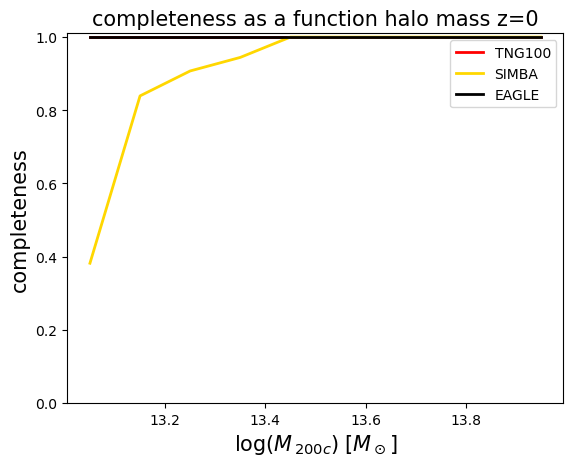

In [48]:
flux_lim = 3*10**-15 #Chandra-cluster sample
lx_lim = flux_lim*area
completeness = 1

selected, unselected = selection(ch_mock, lx_lim, completeness)
completeness_vs_mass(mass_dict, selected, nbins=10)
plt.savefig('../plots/chandra_completeness.pdf')

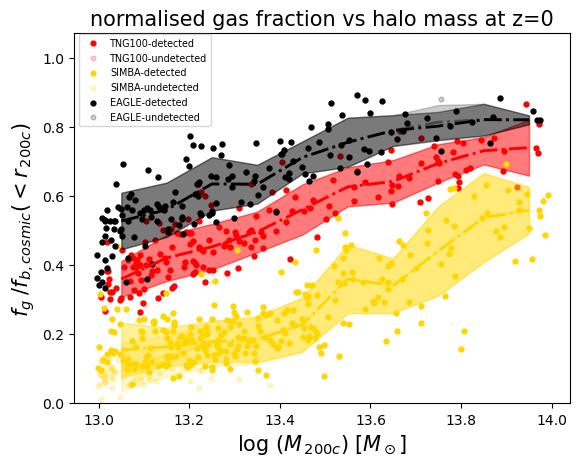

In [49]:
plot_fgas_mass(gasfrac_dict, selected)
plt.savefig('../plots/chandra_fgas_detected.pdf')

# XMM

In [10]:
eff_area = 1250
xmm_mock = xmm_lum_mock(basepaths, haloIDs, eff_area, area, 'x')

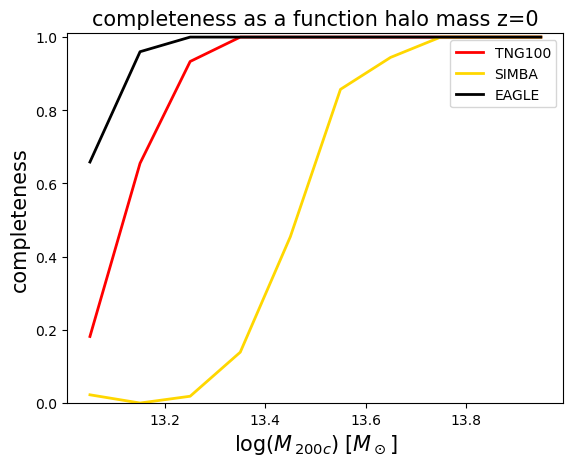

In [25]:
flux_lim = 1.3*10**-14 #XMM-XXL
lx_lim = flux_lim*area
completeness = 1

selected_100, unselected_100 = selection(xmm_mock, lx_lim, completeness)
completeness_vs_mass(mass_dict, selected_100, nbins=10)
plt.savefig('../plots/xmmxxl_completeness.pdf')

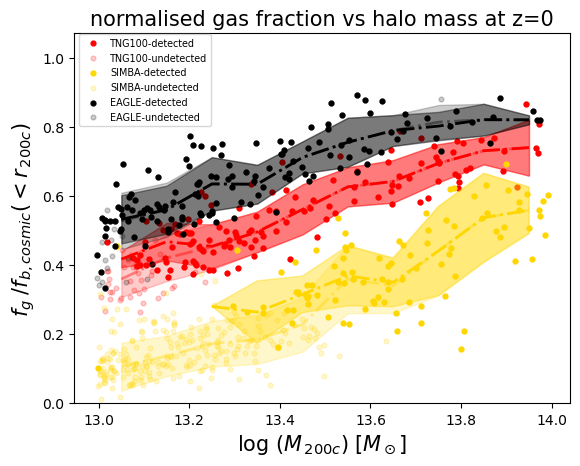

In [26]:
plot_fgas_mass(gasfrac_dict, selected_100)
plt.savefig('../plots/xmmxxl_fgas_detected.pdf')

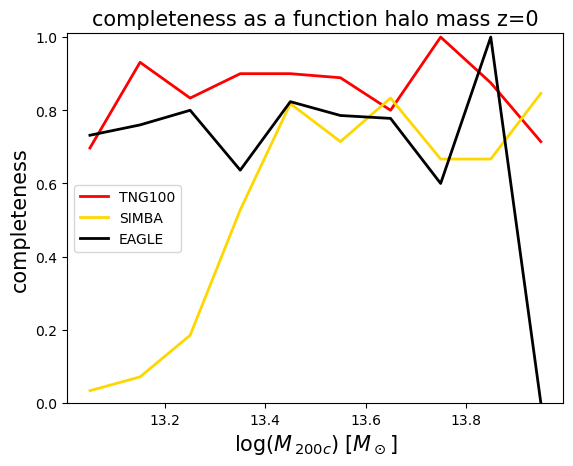

In [39]:
flux_lim = 5*10**-15 #XMM-xcalss_redmapper
lx_lim = flux_lim*area
completeness = 0.8

selected_80, unselected_80 = selection(xmm_mock, lx_lim, completeness)
completeness_vs_mass(mass_dict, selected_80, nbins=10)
plt.savefig('../plots/xclass_completeness.pdf')

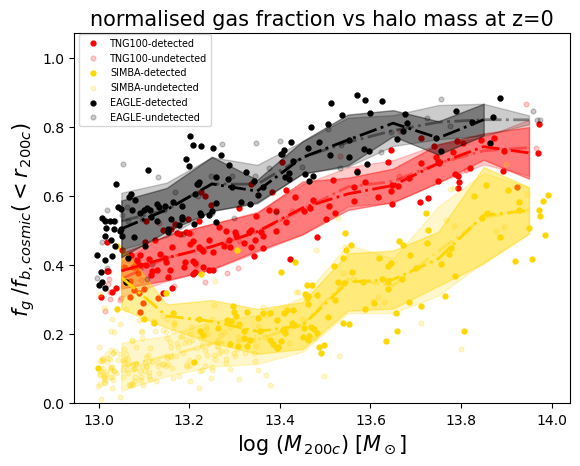

In [40]:
plot_fgas_mass(gasfrac_dict, selected_80)
plt.savefig('../plots/xclass_fgas_detected.pdf')

# eROSITA

In [9]:
eff_area= 2150
t_exp = 1200
er_mock = er_lum_mock(basepaths, haloIDs, eff_area, area, t_exp, 'x')

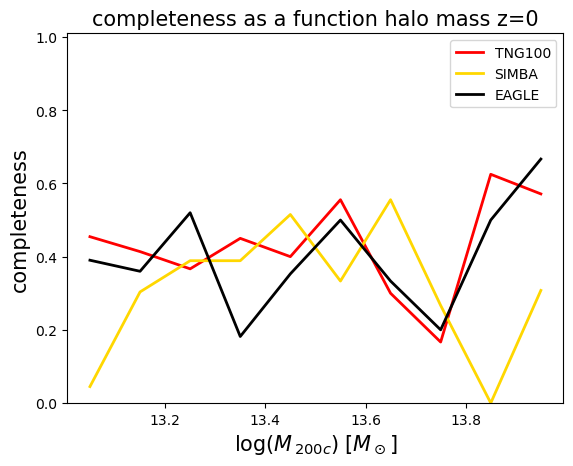

In [216]:
flux_lim = 10**-14 #eFEDS
lx_lim = flux_lim*area
completeness = 0.4

selected_40, unselected_40 = selection(er_mock, lx_lim, completeness)
completeness_vs_mass(mass_dict, selected_40, nbins=10)
plt.savefig('../plots/efeds_completeness.pdf')

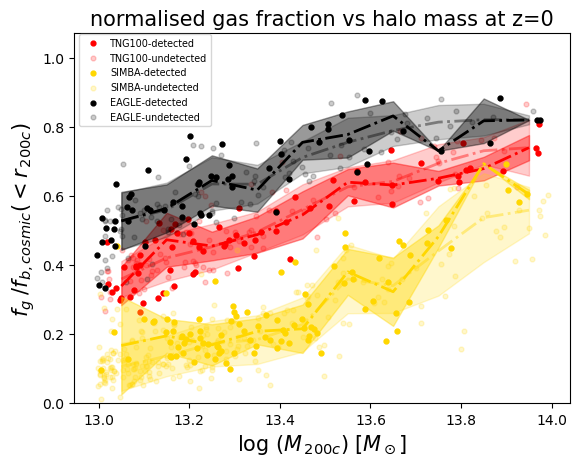

In [217]:
plot_fgas_mass(gasfrac_dict, selected_40)
plt.savefig('../plots/efeds_fgas_detected.pdf')

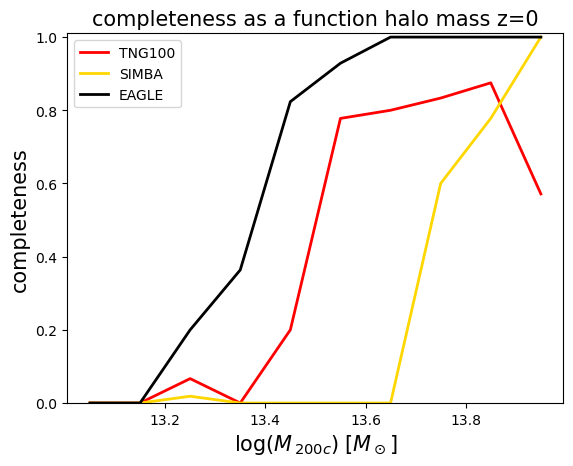

In [218]:
flux_lim = 8*10**-13 #eRASS1
lx_lim = flux_lim*area
completeness = 0.9

selected_90, unselected_90 = selection(er_mock, lx_lim, completeness)
completeness_vs_mass(mass_dict, selected_90, nbins=10)
plt.savefig('../plots/erass1_completeness.pdf')

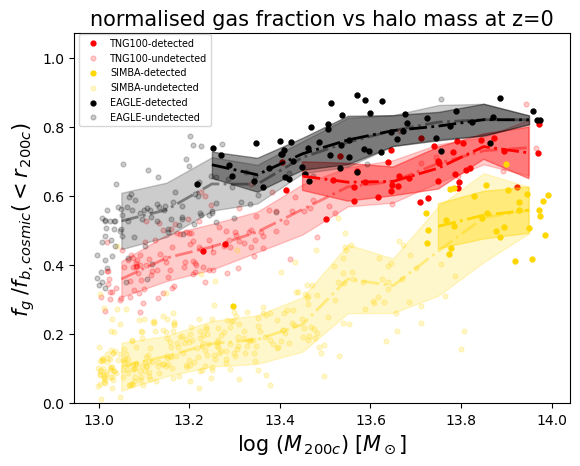

In [219]:
plot_fgas_mass(gasfrac_dict, selected_90)
plt.savefig('../plots/erass1_fgas_detected.pdf')

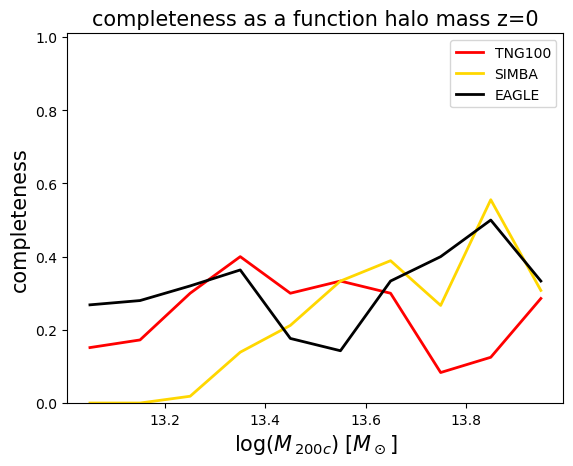

In [233]:
flux_lim = 10**-13 #eRASS1 cosmo
lx_lim = flux_lim*area
completeness = 0.3

selected_30, unselected_30 = selection(er_mock, lx_lim, completeness)
completeness_vs_mass(mass_dict, selected_30, nbins=10)
plt.savefig('../plots/cosmoerass1_completeness.pdf')

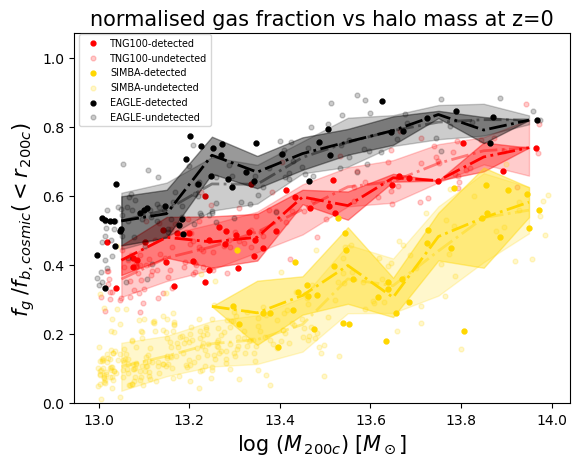

In [234]:
plot_fgas_mass(gasfrac_dict, selected_30)
plt.savefig('../plots/cosmoerass1_fgas_detected.pdf')

In [26]:
flux_lim = 1.5*10**-14 #9*10**-13 # eRASS:1 cluster sample (90% completeness)
lx_lim = flux_lim*area
print('\n','Flux limit = ', flux_lim,'\n', f"Lx limit = {lx_lim:.2e}")


 Flux limit =  1.5e-14 
 Lx limit = 2.28e+40


In [32]:
flux_lim = 1*10**-15 # random  eRASS:1 cluster sample (90% completeness)
lx_lim = flux_lim*area
print('\n','Flux limit = ', flux_lim,'\n', f"Lx limit = {lx_lim:.2e}")


 Flux limit =  1e-15 
 Lx limit = 9.21e+39


In [61]:
#flux_lim = 2.2*10**-16 # chandra cosmos survey soft band (pt sources)
#flux_lim = 3*10**-16 # COSMOS X-ray galaxy groups
#flux_lim = 4*10**-16 # Deep Chandra observations of the stripped galaxy group
flux_lim = 3*10**-15 # CHANDRA SAMPLE OF NEARBY RELAXED GALAXY CLUSTERS # 1.5*10**42 Lx

In [80]:
#flux_lim = 6.5*10**-15 # eFEDS soft band (pt sources)
#flux_lim = 10**-14 # eFEDS cluster sample soft band
flux_lim = 10**-13 # eRASS:1 cosmology cluster sample (30% completeness)
#flux_lim = 8*10**-13 # eRASS:1 cluster sample (90% completeness)